In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os


#from utils import print_signal_qrs, print_signal, calcul_f1, perf


import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from scipy.signal import resample
from scipy.interpolate import UnivariateSpline

import pickle
import joblib

# Le preprocessing dans l'article est un peu bizarre alors j'ai juste demandé à gpt de me faire un truc à peu près

In [2]:
def preprocessing(signal, fs):
    clean_baseline = baseline_wander_removal(signal)
    normalization = normalize_signal(clean_baseline)
    return normalization

def baseline_wander_removal(ecg_signal, window_size=4, sampling_rate=360, subsample_rate=200):
    # Convert window size to number of samples
    window_samples = window_size * sampling_rate
    
    # Initialize an empty array to store the corrected signal
    corrected_signal = np.zeros_like(ecg_signal)
    
    # Process the signal in windows
    for start in range(0, len(ecg_signal), window_samples):
        end = min(start + window_samples, len(ecg_signal))
        segment = ecg_signal[start:end]
        
        # Resample segment to reduce computational load
        resampled_segment = resample(segment, subsample_rate)
        
        # Perform LOESS regression
        x = np.linspace(0, len(resampled_segment) - 1, len(resampled_segment))
        spline = UnivariateSpline(x, resampled_segment, s=len(resampled_segment))
        baseline = spline(x)
        
        # Upsample the baseline back to the original sampling rate
        baseline_full = resample(baseline, len(segment))
        
        # Subtract the baseline from the original segment
        corrected_signal[start:end] = segment - baseline_full
    
    return corrected_signal

def normalize_signal(ecg_signal):
    mean_val = np.mean(ecg_signal)
    std_val = np.std(ecg_signal)
    
    # Subtract mean and divide by standard deviation
    normalized_signal = (ecg_signal - mean_val) / std_val
    
    return normalized_signal

In [9]:
def create_windows(ecg_signal, qrs_positions, fs, num_negative_samples=3):
    points_before = int(100 * fs / 1000)
    points_after = int(300 * fs / 1000)
    total_points = points_before + points_after + 1

    data_windows = []
    labels = []
    
    tolerance = int(40 * fs / 1000)
    
    for qrs in qrs_positions:
        start = qrs - points_before
        end = qrs + points_after + 1
        if start >= 0 and end <= len(ecg_signal):
            window = ecg_signal[start:end]
            if len(window) != total_points:
                print(f"Taille incorrecte: {len(window)} au lieu de {total_points}, start={start}, end={end}")
                continue
            data_windows.append(window)
            labels.append(1)
    
    num_qrs_positions = len(qrs_positions)
    signal_length = len(ecg_signal)
    negative_count = 0
    
    
    data_windows_array = np.array([np.array(window) for window in data_windows if len(window) == total_points])
    
    return data_windows_array, np.array(labels)

In [10]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Créer le modèle
input_shape = (145, 1)  # 145 points par fenêtre, 1 canal
model = create_model(input_shape)
model.summary()

C:\Users\Dieu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 143, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 71, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 69, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 34, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2176)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │         217,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,137 (875.54 KB)

 Trainable params: 224,137 (875.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
X_train_all, X_test_all = [], []
y_train_all, y_test_all = [], []

for file in ['101', '104', '107', '113', '116', '121', '201', '207', '209', '212', '215', '219', '228', '233']:
    print(file)
    df = pd.read_csv(f'data_csv/mit_bih_Arrhythmia/{file}.csv') #207
    ecg_signal = None
    if file == "104":
        ecg_signal = np.array(df["V2"], dtype=np.float32)#[:10000]
    else:
        ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:10000]
    fs = 360
    QRS = df["labels"].dropna().astype(int).tolist()
    labels = np.zeros(len(ecg_signal))

    cleaned_ecg = preprocessing(ecg_signal, fs)
    
    X, y = create_windows(cleaned_ecg, QRS, fs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    X_train_all.extend(X_train)
    X_test_all.extend(X_test)
    y_train_all.extend(y_train)
    y_test_all.extend(y_test)

101
104
107
113
116
121
201
207
209
212
215
219
228
233


In [16]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

input_shape = (145, 1)  # 145 points par fenêtre, 1 canal
model = create_model(input_shape)
history = model.fit(np.array(X_train_all), np.array(y_train_all), epochs=5, batch_size=64)

Epoch 1/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9896 - loss: 0.0183
Epoch 2/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.9915e-06
Epoch 3/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.2030e-07
Epoch 4/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 9.8355e-08
Epoch 5/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 7.1995e-08


In [ ]:
model.save("../benchmark_qrs_detectors/model_CNN.h5")

In [155]:
import numpy as np

def create_windows(ecg_signal, qrs_positions, fs, num_negative_samples=3):
    # Recalculer les points avant et après le QRS en fonction de la fréquence
    points_before = int(100 * fs / 1000)
    points_after = int(300 * fs / 1000)
    total_points = points_before + points_after + 1
    
    # Affiche un ajustement basé sur la nouvelle fréquence si différent de 101 pour fs=250
    if fs == 250 and total_points != 101:
        print(f"Erreur: le nombre total de points par fenêtre est {total_points}, mais 101 sont attendus pour fs=250.")
        points_after += 101 - total_points
        total_points = points_before + points_after + 1  # Recalcule total_points si nécessaire

    data_windows = []
    labels = []
    
    tolerance = int(40 * fs / 1000)
    
    # Fenêtres positives
    for qrs in qrs_positions:
        start = qrs - points_before
        end = qrs + points_after + 1
        if start >= 0 and end <= len(ecg_signal):
            window = ecg_signal[start:end]
            if len(window) != total_points:
                print(f"Taille incorrecte: {len(window)} au lieu de {total_points}, start={start}, end={end}")
                continue
            data_windows.append(window)
            labels.append(1)
    
    # Fenêtres négatives
    num_qrs_positions = len(qrs_positions)
    signal_length = len(ecg_signal)
    negative_count = 0
    
    while negative_count < num_qrs_positions * num_negative_samples:
        start = np.random.randint(0, signal_length - total_points)
        end = start + total_points
        
        # Vérifiez si la fenêtre chevauche un complexe QRS
        is_positive = any(abs(start + points_before - qrs) <= tolerance for qrs in qrs_positions)
        if not is_positive:
            window = ecg_signal[start:end]
            if len(window) != total_points:
                print(f"Taille incorrecte (négative): {len(window)} au lieu de {total_points}, start={start}, end={end}")
                continue
            data_windows.append(window)
            labels.append(0)
            negative_count += 1
    
    # Convertir data_windows en un numpy array de manière sécurisée
    data_windows_array = np.array([np.array(window) for window in data_windows if len(window) == total_points])
    labels_array = np.array(labels)
    
    # Vérifiez si les dimensions sont correctes
    if data_windows_array.ndim == 1 or data_windows_array.shape[1] != total_points:
        print("Erreur dans la transformation finale des fenêtres de données.")
        print(f"Forme finale attendue: (?, {total_points}), obtenue: {data_windows_array.shape}")
    
    return data_windows_array, labels_array

In [156]:
X_train_all, X_test_all = [], []
y_train_all, y_test_all = [], []

for file in range(103, 151):
    print(file)
    try:
        df = pd.read_csv(f'data_csv/european/e0{file}.csv') #207
    except:
        continue
    ecg_signal = None
    
    if "MLIII" in df.columns:
        ecg_signal = np.array(df["MLIII"], dtype=np.float32)#[:10000]
    else:
        continue
    fs = 250
    QRS = df["labels"].dropna().astype(int).tolist()
    labels = np.zeros(len(ecg_signal))

    cleaned_ecg = preprocessing(ecg_signal, fs)
    
    X, y = create_windows(cleaned_ecg, QRS, fs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    X_train_all.extend(X_train)
    X_test_all.extend(X_test)
    y_train_all.extend(y_train)
    y_test_all.extend(y_test)

103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [158]:
input_shape = (101, 1)  # 145 points par fenêtre, 1 canal
model = create_model(input_shape)
history = model.fit(np.array(X_train_all), np.array(y_train_all), epochs=5, batch_size=64)

Epoch 1/5
13338/13338 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9860 - loss: 0.0594
Epoch 2/5
13338/13338 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9919 - loss: 0.0359
Epoch 3/5
13338/13338 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9925 - loss: 0.0326
Epoch 4/5
13338/13338 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9925 - loss: 0.0319
Epoch 5/5
13338/13338 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9929 - loss: 0.0303


In [159]:
model.save("../benchmark_qrs_detectors/model_CNN_european.h5")

In [182]:
ls "../benchmark_qrs_detectors/output/perf/arr.csv"

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est 1AC4-BB4B

 R‚pertoire de C:\Users\Dieu\Octo\Benchmark_QRS_Detectors_SOTA\benchmark_qrs_detectors\output\perf



Fichier introuvable


In [194]:
def create_windows(ecg_signal, qrs_positions, fs, num_negative_samples=3):
    # Recalculer les points avant et après le QRS en fonction de la fréquence
    points_before = int(100 * fs / 1000)
    points_after = int(300 * fs / 1000)
    total_points = points_before + points_after + 1
    
    # Affiche un ajustement basé sur la nouvelle fréquence si différent de 101 pour fs=250
    if total_points != 51:
        print(f"Erreur: le nombre total de points par fenêtre est {total_points}, mais 101 sont attendus pour fs=250.")
        points_after += 51 - total_points
        total_points = points_before + points_after + 1  # Recalcule total_points si nécessaire

    data_windows = []
    labels = []
    
    tolerance = int(40 * fs / 1000)
    
    # Fenêtres positives
    for qrs in qrs_positions:
        start = qrs - points_before
        end = qrs + points_after + 1
        if start >= 0 and end <= len(ecg_signal):
            window = ecg_signal[start:end]
            if len(window) != total_points:
                print(f"Taille incorrecte: {len(window)} au lieu de {total_points}, start={start}, end={end}")
                continue
            data_windows.append(window)
            labels.append(1)
    
    # Fenêtres négatives
    num_qrs_positions = len(qrs_positions)
    signal_length = len(ecg_signal)
    negative_count = 0
    
    while negative_count < num_qrs_positions * num_negative_samples:
        start = np.random.randint(0, signal_length - total_points)
        end = start + total_points
        
        # Vérifiez si la fenêtre chevauche un complexe QRS
        is_positive = any(abs(start + points_before - qrs) <= tolerance for qrs in qrs_positions)
        if not is_positive:
            window = ecg_signal[start:end]
            if len(window) != total_points:
                print(f"Taille incorrecte (négative): {len(window)} au lieu de {total_points}, start={start}, end={end}")
                continue
            data_windows.append(window)
            labels.append(0)
            negative_count += 1
    
    # Convertir data_windows en un numpy array de manière sécurisée
    data_windows_array = np.array([np.array(window) for window in data_windows if len(window) == total_points])
    labels_array = np.array(labels)
    
    # Vérifiez si les dimensions sont correctes
    if data_windows_array.ndim == 1 or data_windows_array.shape[1] != total_points:
        print("Erreur dans la transformation finale des fenêtres de données.")
        print(f"Forme finale attendue: (?, {total_points}), obtenue: {data_windows_array.shape}")
    
    return data_windows_array, labels_array

In [197]:
X_train_all, X_test_all = [], []
y_train_all, y_test_all = [], []

for file in range(800, 845):
    print(file)
    df = None
    try:
        df = pd.read_csv(f'data_csv/mit_bih_supraventricular/{file}.csv') #207
    except:
        continue
    
    ecg_signal = np.array(df["ECG1"], dtype=np.float32)#[:10000]

    fs = 128
    QRS = df["labels"].dropna().astype(int).tolist()
    labels = np.zeros(len(ecg_signal))

    cleaned_ecg = preprocessing(ecg_signal, fs)
    
    X, y = create_windows(cleaned_ecg, QRS, fs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    X_train_all.extend(X_train)
    X_test_all.extend(X_test)
    y_train_all.extend(y_train)
    y_test_all.extend(y_test)

800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844


In [198]:
input_shape = (51, 1)  # 145 points par fenêtre, 1 canal
model = create_model(input_shape)
history = model.fit(np.array(X_train_all), np.array(y_train_all), epochs=5, batch_size=64)

C:\Users\Dieu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9849 - loss: 0.0525
Epoch 2/5
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9954 - loss: 0.0179
Epoch 3/5
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9964 - loss: 0.0149
Epoch 4/5
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9965 - loss: 0.0137
Epoch 5/5
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9971 - loss: 0.0126


In [199]:
model.save("../benchmark_qrs_detectors/model_CNN_supra.h5")

In [201]:
df = pd.read_csv(f'../benchmark_qrs_detectors/output/perf/CNN_mit-bih-supraventricular-arrhythmia_100.csv', index_col=0)
# Convertir l'index en entier pour pouvoir le comparer
df.index = df.index.astype(int)

# Filtrer les lignes où l'index est supérieur à 153
filtered_df = df[df.index > 845]
filtered_df.mean()

nbofbeats    2417.408163
FP             24.448980
FN             11.693878
F              36.142857
F(%)            1.377755
P+(%)          99.102041
Se(%)          99.565918
F1(%)          99.321837
dtype: float64

In [203]:
X_train_all, X_test_all = [], []
y_train_all, y_test_all = [], []

for file in ['14149','14134','14046']:
    print(file)
    df = None
    try:
        df = pd.read_csv(f'data_csv/mit_bih_long_term/{file}.csv') #207
    except:
        continue
    
    ecg_signal = np.array(df["ECG1"], dtype=np.float32)#[:10000]

    fs = 128
    QRS = df["labels"].dropna().astype(int).tolist()
    labels = np.zeros(len(ecg_signal))

    cleaned_ecg = preprocessing(ecg_signal, fs)
    
    X, y = create_windows(cleaned_ecg, QRS, fs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    X_train_all.extend(X_train)
    X_test_all.extend(X_test)
    y_train_all.extend(y_train)
    y_test_all.extend(y_test)

14149
14134
14046


In [204]:
input_shape = (51, 1)  # 145 points par fenêtre, 1 canal
model = create_model(input_shape)
history = model.fit(np.array(X_train_all), np.array(y_train_all), epochs=5, batch_size=64)

C:\Users\Dieu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
19368/19368 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9971 - loss: 0.0134
Epoch 2/5
19368/19368 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9986 - loss: 0.0067
Epoch 3/5
19368/19368 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.9986 - loss: 0.0063
Epoch 4/5
19368/19368 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.9987 - loss: 0.0057
Epoch 5/5
19368/19368 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.9987 - loss: 0.0060


In [205]:
model.save("../benchmark_qrs_detectors/model_CNN_long_term.h5")

In [206]:
df = pd.read_csv(f'../benchmark_qrs_detectors/output/perf/CNN_mit-bih-supraventricular-arrhythmia_100.csv', index_col=0)
# Convertir l'index en entier pour pouvoir le comparer
df.index = df.index.astype(int)

# Filtrer les lignes où l'index est supérieur à 153
filtered_df = df[df.index > 14149]
filtered_df.mean()

FileNotFoundError: [Errno 2] No such file or directory: '../benchmark_qrs_detectors/output/perf/CNN_mit-bih-supraventricular-arrhythmia_100.csv'

In [179]:
df = pd.read_csv(f'../benchmark_qrs_detectors/output/perf/CNN_european-stt_100.csv', index_col=0)
# Convertir l'index en entier pour pouvoir le comparer
df.index = df.index.astype(int)

# Filtrer les lignes où l'index est supérieur à 153
filtered_df = df[df.index > 153]
filtered_df.mean()

nbofbats    9270.868852
FP           153.262295
FN            51.918033
F            205.180328
F(%)           2.224918
P+(%)         98.437213
S(%)          99.429508
F1(%)         98.910656
dtype: float64

In [188]:
filtered_df

,nbofbeats,FP,FN,F,F(%),P+(%),Se(%),F1(%)
100,2273,5,1,6,0.26,99.78,99.96,99.87
101,1865,18,0,18,0.97,99.04,100.00,99.52
102,2187,64,0,64,2.93,97.16,100.00,98.56
103,2084,5,0,5,0.24,99.76,100.00,99.88
104,2229,214,2,216,9.69,91.23,99.91,95.37
105,2572,220,13,233,9.06,92.08,99.49,95.65
106,2027,12,0,12,0.59,99.41,100.00,99.70
107,2137,12,1,13,0.61,99.44,99.95,99.70
108,1763,257,25,282,16.00,87.12,98.58,92.50
109,2532,1,5,6,0.24,99.96,99.80,99.88


In [191]:
df = pd.read_csv("../benchmark_qrs_detectors/output/perf/arr.csv", index_col=0)
# Convertir l'index en entier pour pouvoir le comparer
#df.index = df.index.astype(int)
excluded_indices = [101, 104, 107, 113, 116, 121, 201, 207, 209, 212, 215, 219, 228, 233]
filtered_df = df[~df.index.isin(excluded_indices)]
filtered_df.mean()

nbofbeats    2263.764706
FP             56.676471
FN              4.411765
F              61.088235
F(%)            2.691176
P+(%)          97.707941
Se(%)          99.817647
F1(%)          98.715588
dtype: float64

In [136]:
X_train_all, X_test_all = [], []
y_train_all, y_test_all = [], []

for file in ['00', '06', '12', '18', '24']:
    print(file)
    df = pd.read_csv(f'data_csv/mit_bih_noise_stress/118e{file}.csv') #207
    ecg_signal = None
    ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:10000]
    fs = 360
    QRS = df["labels"].dropna().astype(int).tolist()
    labels = np.zeros(len(ecg_signal))

    cleaned_ecg = preprocessing(ecg_signal, fs)
    
    X, y = create_windows(cleaned_ecg, QRS, fs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    X_train_all.extend(X_train)
    X_test_all.extend(X_test)
    y_train_all.extend(y_train)
    y_test_all.extend(y_test)

00
06
12
18
24


In [138]:
input_shape = (145, 1)  # 145 points par fenêtre, 1 canal
model = create_model(input_shape)
history = model.fit(np.array(X_train_all), np.array(y_train_all), epochs=5, batch_size=32)

Epoch 1/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9829 - loss: 0.0735
Epoch 2/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9930 - loss: 0.0299
Epoch 3/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9938 - loss: 0.0262
Epoch 4/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9950 - loss: 0.0209
Epoch 5/5
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9954 - loss: 0.0180


In [139]:
model.save("../benchmark_qrs_detectors/model_CNN_full_noisy.h5")

In [ ]:
mit_bih_noise_stress

In [125]:
df = pd.read_csv('data_csv/mit_bih_noise_stress/118e06.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:10000]
fs = 360
QRS = df["labels"].dropna().astype(int).tolist()
labels = np.zeros(len(ecg_signal))

cleaned_ecg = preprocessing(ecg_signal, fs)

In [ ]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/100.csv') #207


In [135]:
df = pd.read_csv('data_csv/mit_bih_noise_stress/118e24.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:10000]
fs = 360
QRS = df["labels"].dropna().astype(int).tolist()
labels = np.zeros(len(ecg_signal))

cleaned_ecg = preprocessing(ecg_signal, fs)

X, y = create_windows(cleaned_ecg, QRS, fs)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
input_shape = (145, 1)  # 145 points par fenêtre, 1 canal
model = create_model(input_shape)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=3, batch_size=16, validation_data=(X_test, y_test))
model.save("../benchmark_qrs_detectors/model_CNN_noise_24.h5")

Epoch 1/3


C:\Users\Dieu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


570/570 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9866 - loss: 0.0684 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 2/3
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9969 - loss: 0.0236 - val_accuracy: 0.9892 - val_loss: 0.0157
Epoch 3/3
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9954 - loss: 0.0285 - val_accuracy: 1.0000 - val_loss: 1.1452e-04


signal de longueur: 1000


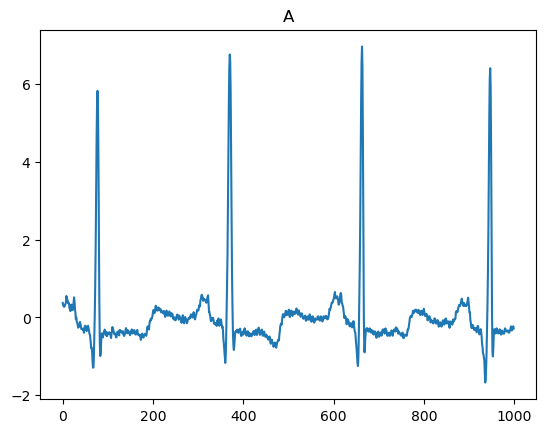

In [47]:
print_signal(cleaned_ecg[:1000])

In [17]:
y.sum()

1873

In [18]:
len(y)

7495

In [76]:
import pickle
joblib.dump(model, open("../benchmark_qrs_detectors/model_CNN", 'wb'))

In [87]:
model.save("../benchmark_qrs_detectors/model_CNN.h5")

In [25]:
def extract_windows_sig(signal, fs):
    # Points avant et après basés sur la fréquence d'échantillonnage
    points_before = int(100 * fs / 1000)
    points_after = int(300 * fs / 1000)
    total_points = points_before + points_after + 1
    
    if total_points != 145:
        raise ValueError(f"La fenêtre calculée a {total_points} points, mais 145 sont attendus.")
    
    # Extraire les fenêtres pour chaque point dans cleaned_ecg
    windows = []
    for i in range(len(signal)):
        start = i - points_before
        end = i + points_after + 1
        if start >= 0 and end <= len(signal):
            window = signal[start:end]
            if len(window) == 145:
                windows.append(window)
    
    return np.array(windows)


In [81]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:10000]
fs = 360
QRS = df["labels"].dropna().astype(int).tolist()
labels = np.zeros(len(ecg_signal))

cleaned_ecg = preprocessing(ecg_signal, fs)
X = extract_windows_sig(cleaned_ecg, fs)
pred = model.predict(X)

20308/20308 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


In [82]:
predos = pred.flatten()

In [83]:
def regroup(peaks, thr):
    diff = peaks[1:]-peaks[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=thr)])
    temp = [peaks[gps==i] for i in range(gps[-1]+1)]
    max_sublist = []
    return [np.mean(sublist).astype(int) for sublist in temp]

In [84]:
pred_frame = [a+36 for a in range(len(predos)) if predos[a] >= 0.5]

In [85]:
final_pred = regroup(np.array(pred_frame), 20)

In [86]:
perf(QRS, final_pred, 36, True)

(2260,
 332,
 324,
 0.8732612055641422,
 [array([9]),
  array([1429]),
  array([2869]),
  array([4311]),
  array([11659]),
  array([13868]),
  array([13965, 13967, 14001]),
  array([14750]),
  array([15094]),
  array([15586]),
  array([15726, 15759, 15775]),
  array([16083, 16112, 16138, 16157]),
  array([16214]),
  array([16324]),
  array([16441]),
  array([16554]),
  array([16665]),
  array([17191, 17218, 17228]),
  array([17304]),
  array([17509, 17511, 17546]),
  array([17670]),
  array([17798]),
  array([17923]),
  array([18080]),
  array([18350]),
  array([18396]),
  array([19715]),
  array([19760]),
  array([20255]),
  array([21045]),
  array([21092]),
  array([21731]),
  array([21827]),
  array([22262]),
  array([22774]),
  array([23313]),
  array([25627]),
  array([26396, 26399, 26430]),
  array([27256]),
  array([28035, 28039, 28072]),
  array([28179, 28182, 28212]),
  array([29585]),
  array([30235]),
  array([46901, 46903, 46934]),
  array([47591, 47596, 47630]),
  array([4